<a href="https://colab.research.google.com/github/andrewyyip/Capstone_Project_2/blob/master/Capstone_2_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Create Training DataFrame

In [0]:
df_train = pd.read_csv('/content/gdrive/My Drive/Capstone Project 2/train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/Capstone Project 2/test.csv')

In [0]:
df_train.label = df_train.label.astype(str)
df_test.label = df_test.label.astype(str)

In [0]:
#Shuffle dataframes
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

In [0]:
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras import regularizers, optimizers
from keras import Sequential

In [0]:
datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.3)
test_datagen = ImageDataGenerator(rescale = 1/255)

In [0]:
image_size = (100,150)
#484, 660

In [23]:
train_generator = datagen.flow_from_dataframe(dataframe = df_train, 
                                              x_col = 'file_path', 
                                              y_col = 'label', 
                                              directory = None,
                                              subset = 'training',
                                              target_size = image_size, 
                                              batchsize = 32, 
                                              shuffle = True,
                                              class_mode = 'binary')

val_generator = datagen.flow_from_dataframe(dataframe = df_train,
                                            x_col = 'file_path',
                                            y_col = 'label',
                                            directory = None,
                                            subset = 'validation',
                                            target_size = image_size,
                                            batchsize = 32,
                                            shuffle = True,
                                            class_mode = 'binary')

test_generator = test_datagen.flow_from_dataframe(dataframe = df_test,
                                                  x_col = 'file_path',
                                                  y_col = 'label',
                                                  directory = None,
                                                  target_size = image_size,
                                                  batchsize = 32,
                                                  shuffle = False,
                                                  class_mode = 'binary')
                                             

Found 3652 validated image filenames belonging to 2 classes.
Found 1564 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [24]:
model = Sequential()

model.add(Conv2D(32, (3,3), strides = (1,1), activation = 'relu', input_shape = (image_size[0], image_size[1],3)))

model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), strides = (1,1), activation = 'relu', input_shape = (image_size[0], image_size[1],3)))

model.add(MaxPooling2D((2,2)))

model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid'))


In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 148, 32)       896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 36, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 36, 32)        128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 26496)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

In [0]:
optimizer = optimizers.SGD(lr = 0.01, momentum = 0.0, nesterov = False)
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy', f1_m, recall_m, precision_m])

In [30]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_val = val_generator.n // val_generator.batch_size
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = step_size_train,
                              validation_data = val_generator,
                              validation_steps = step_size_val,
                              epochs = 10)



Epoch 1/10
114/114 [==============================] - 2301s 20s/step - loss: 0.1954 - acc: 0.9359 - f1_m: 0.9546 - recall_m: 0.9542 - precision_m: 0.9615 - val_loss: 0.1341 - val_acc: 0.9492 - val_f1_m: 0.9639 - val_recall_m: 0.9368 - val_precision_m: 0.9943
Epoch 2/10
114/114 [==============================] - 62s 541ms/step - loss: 0.0750 - acc: 0.9742 - f1_m: 0.9823 - recall_m: 0.9836 - precision_m: 0.9819 - val_loss: 0.3219 - val_acc: 0.9302 - val_f1_m: 0.9545 - val_recall_m: 0.9854 - val_precision_m: 0.9269
Epoch 3/10
114/114 [==============================] - 60s 530ms/step - loss: 0.0480 - acc: 0.9838 - f1_m: 0.9888 - recall_m: 0.9902 - precision_m: 0.9880 - val_loss: 0.1104 - val_acc: 0.9706 - val_f1_m: 0.9804 - val_recall_m: 0.9865 - val_precision_m: 0.9753
Epoch 4/10
114/114 [==============================] - 61s 533ms/step - loss: 0.0781 - acc: 0.9715 - f1_m: 0.9807 - recall_m: 0.9824 - precision_m: 0.9805 - val_loss: 12.0570 - val_acc: 0.2520 - val_f1_m: 0.0000e+00 - val_

In [31]:
test_generator.reset()
step_size_test = test_generator.n // test_generator.batch_size
model.evaluate_generator(generator = test_generator)

[1.692403678710644,
 0.7756410256410257,
 0.8433921306561201,
 0.9917378914661896,
 0.739533143165784]

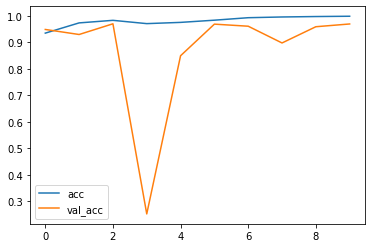

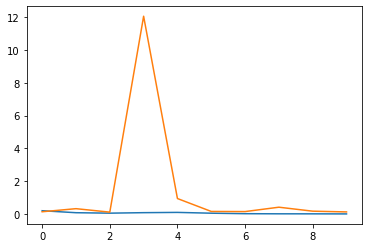

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [77]:
len(df_test[df_test.label=='0'])

234

In [78]:
len(df_test[df_test.label=='1'])

390

In [145]:
print(len(df_train))
print(len(df_train[df_train.label == '0']))
print(len(df_train[df_train.label == '1']))

5216
1341
3875


In [0]:
np.asarray(df_test.label).shape

(624,)